In [12]:
'''Install Packages'''
!pip install graphviz


Error processing line 1 of /Users/watsonblair/anaconda3/lib/python3.11/site-packages/distutils-precedence.pth:

  Traceback (most recent call last):
    File "<frozen site>", line 186, in addpackage
    File "<string>", line 1, in <module>
  ModuleNotFoundError: No module named '_distutils_hack'

Remainder of file ignored


In [13]:
'''Imports'''
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from prettytable import PrettyTable
import graphviz

'''Import Utils'''


'''Import Data'''
from sklearn.datasets import load_digits, fetch_california_housing

'''Import Data Processing Utilities'''
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error, f1_score
from sklearn.decomposition import PCA

'''Import Predictors'''
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree, export_graphviz
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from skopt import BayesSearchCV

'''Import Tuning Utilities'''
from skopt.space import Integer
from skopt.space import Real
from skopt.space import Categorical
from skopt.utils import use_named_args
from skopt import gp_minimize
from skopt.plots import plot_objective, plot_histogram, plot_convergence, plot_gaussian_process
from sklearn.model_selection import GridSearchCV


In [14]:
'''Scoring Criteria Space'''
scoringCriteria = [
    'positive_likelihood_ratio', 'f1_micro', 'v_measure_score', 'roc_auc_ovr_weighted',
    'adjusted_rand_score', 'neg_mean_squared_log_error', 'r2', 'precision_macro',
    'roc_auc_ovo_weighted', 'neg_median_absolute_error', 'matthews_corrcoef', 'precision_samples',
    'jaccard_micro', 'balanced_accuracy', 'precision_micro', 'recall_micro', 'f1_samples',
    'recall', 'jaccard', 'neg_mean_poisson_deviance', 'rand_score', 'jaccard_weighted',
    'neg_mean_absolute_percentage_error', 'precision_weighted', 'average_precision',
    'neg_log_loss', 'recall_samples', 'recall_weighted', 'accuracy', 'homogeneity_score',
    'neg_mean_absolute_error', 'adjusted_mutual_info_score', 'roc_auc', 'completeness_score',
    'f1_macro', 'roc_auc_ovo', 'recall_macro', 'top_k_accuracy', 'f1', 'roc_auc_ovr',
    'normalized_mutual_info_score', 'fowlkes_mallows_score', 'mutual_info_score', 'explained_variance',
    'max_error', 'neg_negative_likelihood_ratio', 'neg_brier_score', 'neg_mean_squared_error',
    'f1_weighted', 'neg_root_mean_squared_error', 'jaccard_samples', 'neg_mean_gamma_deviance',
    'jaccard_macro', 'precision'
    ]

In [15]:
'''Fetch Regressor Data'''
cal_housing = fetch_california_housing(as_frame=True)
# print(cal_housing.data)
# print(cal_housing.target)
print(cal_housing.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block group
        - HouseAge      median house age in block group
        - AveRooms      average number of rooms per household
        - AveBedrms     average number of bedrooms per household
        - Population    block group population
        - AveOccup      average number of household members
        - Latitude      block group latitude
        - Longitude     block group longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived

In [16]:
'''Regressor data EDA: Outliers'''

outlierTable = PrettyTable(['Feature', 'Outlier Count'])

for column in cal_housing.data.columns:
    Q1 = cal_housing.data[column].quantile(0.25)
    Q3 = cal_housing.data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5*IQR
    upper = Q3 + 1.5*IQR
    outlierCount = np.array(cal_housing.data[column] >= upper).sum() + np.array(cal_housing.data[column] <= lower).sum()
    outlierTable.add_row([column, outlierCount])
    # print(f"{column}: {outlierCount}")

print(outlierTable)


+------------+---------------+
|  Feature   | Outlier Count |
+------------+---------------+
|   MedInc   |      681      |
|  HouseAge  |       0       |
|  AveRooms  |      511      |
| AveBedrms  |      1424     |
| Population |      1198     |
|  AveOccup  |      711      |
|  Latitude  |       0       |
| Longitude  |       0       |
+------------+---------------+


In [17]:
'''Data Cleaning and Pre-Processing: Outlier Removal'''
cleanData = cal_housing.data
cleanData['y'] = cal_housing.target

# cleanData = cleanData.drop(columns=['Longitude', 'Latitude'])
for feature in ['AveBedrms', 'AveRooms', 'AveOccup', 'Population']:
    cleanData = cleanData[(np.abs(stats.zscore(cleanData[feature])) < 2.5)]

# DATA CLEANING TODOs
# TODO: Bin Lat/Long groupings into city/town clusters. look for available geo-fencing data for cluster labeling - can we do a graph of centroids on top of map?
# TODO: Fix Skew for Population, MedIncome, AvgOccup, AvgBedroom, Target
# TODO: Feature Engineering / Reduction

cleanTarget = cleanData['y'].to_list()
cleanData.drop(columns=['y'], inplace=True)

Evaluation Metric: None
val. score: 0.49966573021949656
test score: -2.0175105154003297


/Users/watsonblair/anaconda3/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(


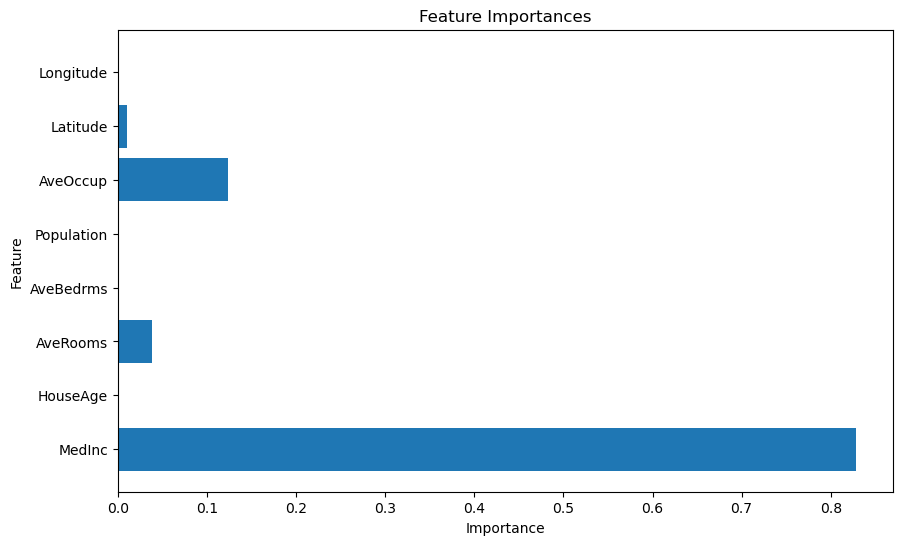

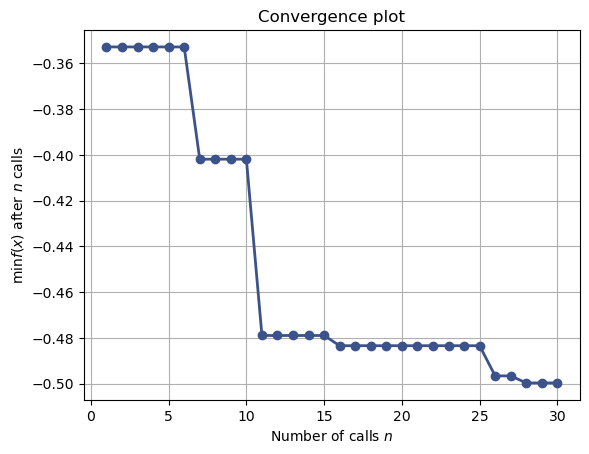

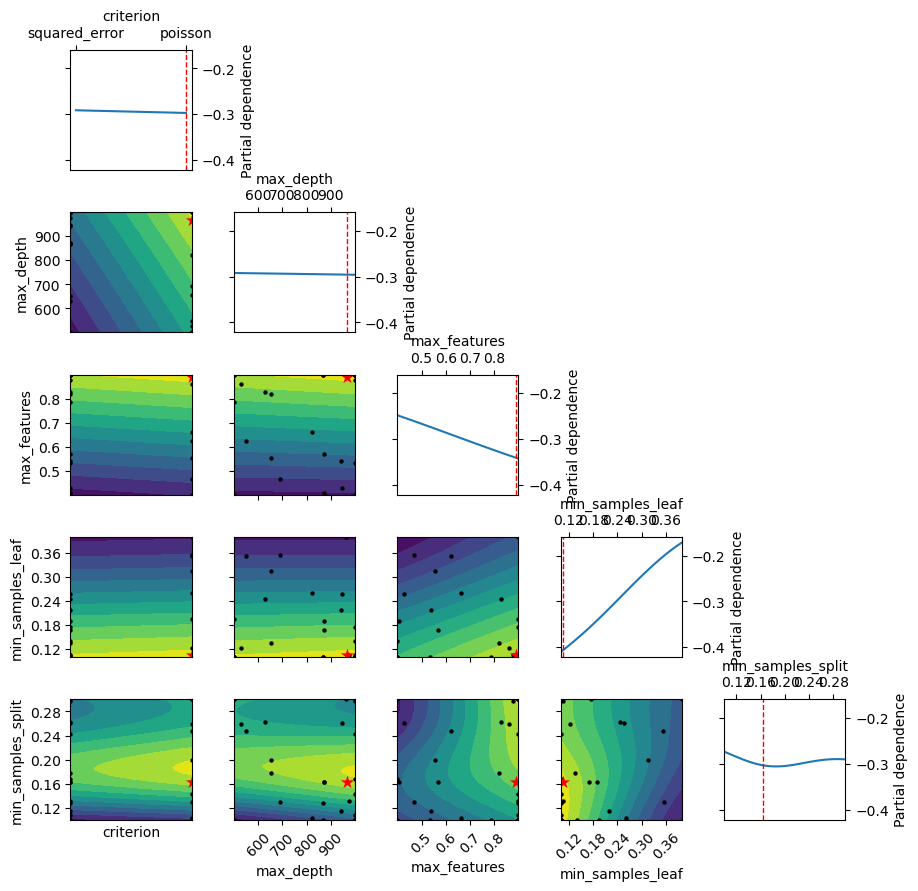

In [18]:
modelData = cleanData.copy()

# paramSpace = {
#             'regress__criterion': ['squared_error','poisson'],
#             'regress__max_depth': Integer(500,1000),
#             'regress__min_samples_split': Real(0.1, 0.3),
#             'regress__min_samples_leaf': Real(0.1, 0.4),
#             'regress__max_features': Real(0.4, 0.9),
#             'pca__n_components': Integer(1,len(cleanData.columns)),
#             'scaler__with_mean': [True, False],
#             'scaler__with_std': [True, False],
#         }
paramSpace = {
            'criterion': ['squared_error','poisson'],
            'max_depth': Integer(500,1000),
            'min_samples_split': Real(0.1, 0.3),
            'min_samples_leaf': Real(0.1, 0.4),
            'max_features': Real(0.4, 0.9),
        }

X_train, X_test, y_train, y_test = train_test_split(modelData, cleanTarget, test_size=0.3, random_state=42)


opt = BayesSearchCV(
    # pipe,
    DecisionTreeRegressor(),
    paramSpace,
    n_iter=30,
    cv=10,
    )

pipe = Pipeline([
    ('scaler', StandardScaler(with_mean=True)),
    ('regress',opt)])
pipe.fit(X_train, y_train)

# predicted = opt.best_estimator_.predict(X_test)
# opt = pipe.steps[-1][-1]
print('Evaluation Metric:', opt.get_params()['scoring'])
print("val. score: %s" % opt.best_score_)
print("test score: %s" % opt.score(X_test, y_test))

# .setps only applies when a sklearn pipe is uesed.
# bestEstimator = opt.best_estimator_.steps[-1][1]
bestEstimator = opt.best_estimator_
features = modelData.columns
importance = bestEstimator.feature_importances_

if(len(features) == len(importance)):
    plt.figure(figsize=(10, 6))
    plt.barh(list(modelData.columns), importance)
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title('Feature Importances')
    plt.show()

ax = plot_convergence(
                opt.optimizer_results_[0],
                # n_minimum_search=int(1e8)
                )

plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.show()

# if(len(features) == len(importance)):
# opt.best_estimator_.steps[-1][-1],filled=True,rounded=True,special_characters=True,

dot_data = export_graphviz(
    opt.best_estimator_,filled=True,rounded=True,special_characters=True,
    feature_names=modelData.columns)

graph = graphviz.Source(dot_data)
graph
plt.show()

ax = plot_objective(
                opt.optimizer_results_[0],
                n_minimum_search=int(1e8)
                )

plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.show()



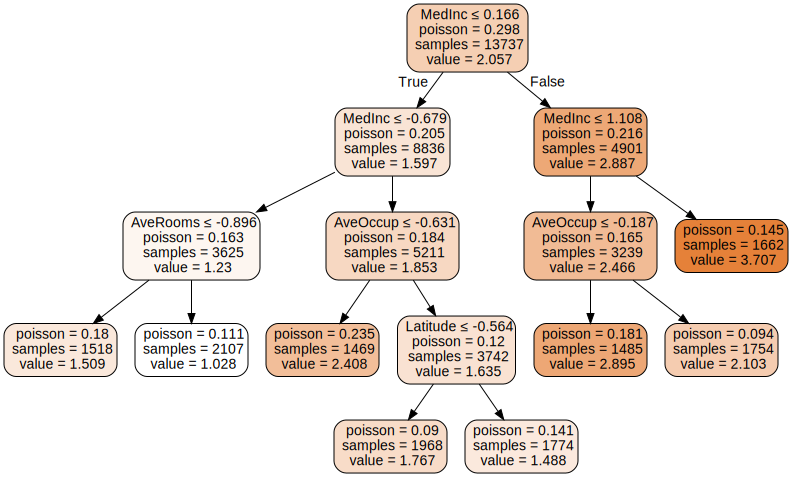

In [19]:
# 

from sklearn.tree import export_text, plot_tree, export_graphviz
import graphviz


# export_text(opt.best_estimator_,
#             feature_names=['MedInc','HouseAge','AveRooms','AveBedrms',
#                            'Population','AveOccup','Latitude','Longitude'])

# plot_tree(opt.best_estimator_,
#             feature_names=['MedInc','HouseAge','AveRooms','AveBedrms',
#                            'Population','AveOccup','Latitude','Longitude'])

# opt.best_estimator_.steps[-1][-1],filled=True,rounded=True,special_characters=True,

dot_data = export_graphviz(
    opt.best_estimator_,filled=True,rounded=True,special_characters=True,
    feature_names=modelData.columns)

graph = graphviz.Source(dot_data)
graph

In [20]:
# print(X_test[1:4])
# for test in X_test[1:2]:
#     print(test)
# for test in X_test[0:-1]:
#     node_indicator = opt.best_estimator_.decision_path(test)
#     print(node_indicator)

node_indicator = opt.best_estimator_.decision_path(X_test[1:10])
print(node_indicator)

  (0, 0)	1
  (0, 10)	1
  (0, 14)	1
  (1, 0)	1
  (1, 10)	1
  (1, 14)	1
  (2, 0)	1
  (2, 10)	1
  (2, 14)	1
  (3, 0)	1
  (3, 10)	1
  (3, 14)	1
  (4, 0)	1
  (4, 10)	1
  (4, 14)	1
  (5, 0)	1
  (5, 10)	1
  (5, 14)	1
  (6, 0)	1
  (6, 10)	1
  (6, 14)	1
  (7, 0)	1
  (7, 10)	1
  (7, 14)	1
  (8, 0)	1
  (8, 10)	1
  (8, 14)	1


/Users/watsonblair/anaconda3/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(


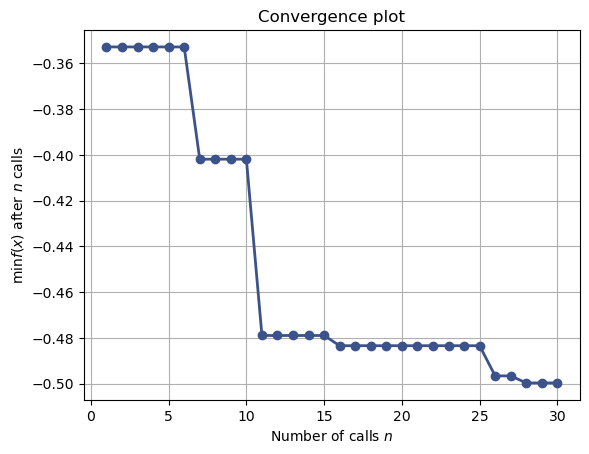

In [21]:
# from skopt.plots import plot_objective, plot_histogram, plot_convergence, plot_gaussian_process

ax = plot_convergence(
                opt.optimizer_results_[0],
                # n_minimum_search=int(1e8)
                )

plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.show()


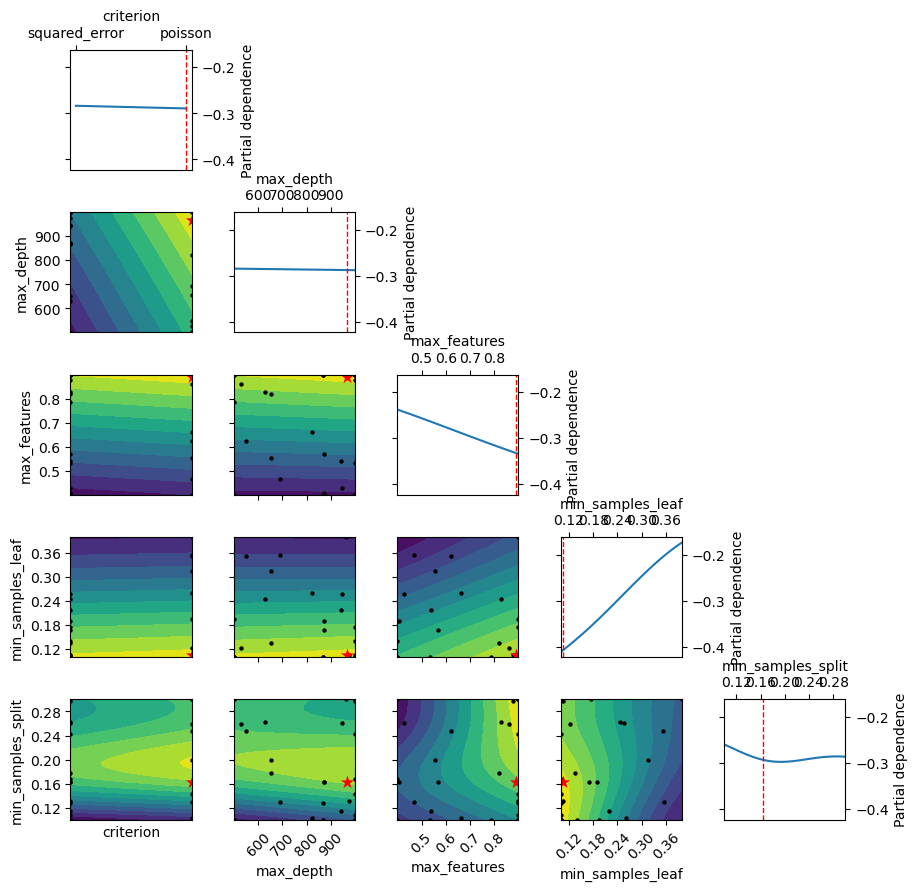

In [22]:
# from skopt.plots import plot_objective, plot_histogram, plot_convergence, plot_gaussian_process

ax = plot_objective(
                opt.optimizer_results_[0],
                n_minimum_search=int(1e8)
                )

plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.show()

In [23]:
regressor = opt.best_estimator_.steps[-1][1]
features = modelData.columns
importance = regressor.feature_importances_

plt.figure(figsize=(10, 6))
plt.barh(list(modelData.columns), importance)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.show()

AttributeError: 'DecisionTreeRegressor' object has no attribute 'steps'

In [ ]:
regressor = opt.best_estimator_.steps[-1][-1]

importance = regressor.feature_importances_

# print(regressor.cost_complexity_pruning_path(X_test, y_test))

# print(regressor.features)
print(len(importance))

opt.feature_names_in_

plot_tree(regressor)
